In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import matplotlib.gridspec as gridspec
from scipy.signal import butter, lfilter, find_peaks
from sklearn import decomposition

import mne

import os


import glob

from utils import *

from time import sleep

In [2]:
foldername = '../../../Originals/procesados/'

In [3]:
filenames = sorted(os.listdir(foldername))

# Concatenación de todos los eeg data

In [4]:
all_eeg_data = []
for f in filenames:
    eeg_data, _, _, _ = get_egg_data(foldername + f)
    all_eeg_data.append(eeg_data)

In [5]:
mont1020 = mne.channels.make_standard_montage('standard_1020')
# Choose what channels you want to keep 
# Make sure that these channels exist e.g. T1 does not exist in the standard 10-20 EEG system!
kept_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 
                 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'FC1', 'FC2',
                 'FC5', 'FC6','CP1','CP2','CP5','CP6','AFz','Fpz','POz']

ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
mont1020_30 = mont1020.copy()
# Keep only the desired channels
mont1020_30.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]
# Keep the first three rows as they are the fiducial points information
mont1020_30.dig = mont1020.dig[0:3]+kept_channel_info
info_eeg = mne.create_info(ch_names=mont1020_30.ch_names, sfreq=128,
                            ch_types='eeg').set_montage(mont1020_30)

In [6]:
df_all_eeg_data = pd.concat([pd.DataFrame(x.T) for x in all_eeg_data])

In [7]:
df_all_eeg_data.reset_index(inplace=True, drop=True)

In [8]:
all_eeg_data_numpy = df_all_eeg_data.to_numpy()

In [9]:
df_all_eeg_data.shape

(76810, 30)

In [10]:
df_all_eeg_data = df_all_eeg_data.T

# Tarea 1: Inspección de los mapas topográficos para los máximos de GFP

### No entiendo muy bien que se refiere con esto 
Encontrar los picos máximos del GFP (PGF P ), guardar los mapas para cada máximo
( ~xn). \ 
Estudiar la presencia de mapas outliers. Para ello puede usar PCA y/o clustering jerarquico y/o matriz de distancias.

In [11]:
srate = 128

In [12]:
df_all_eeg_data.shape

(30, 76810)

In [13]:
gfp, gfp_peaks, gfp_values, gfp2, n_gfp = calculo_gfp(df_all_eeg_data, srate, 'Nope')

In [14]:
gfp.shape

(76810,)

In [15]:
gfp_peaks

array([    5,    10,    17, ..., 76796, 76800, 76807])

In [16]:
gfp_values

5        7.276428
10       5.238829
17       3.388585
21       4.178985
28       4.070243
           ...   
76783    4.182255
76788    6.040142
76796    5.606688
76800    5.746762
76807    4.397674
Length: 13135, dtype: float64

## Sacar los outliers con PCA y/o clustering jerarquico y/o matriz de distancias

In [17]:
X = df_all_eeg_data.T.loc[gfp_peaks].T

In [18]:
pca = decomposition.PCA(n_components=5)
pca.fit(X)

PCA(n_components=5)

In [19]:
pcs = pca.transform(X)
print(pcs.shape)

(30, 5)


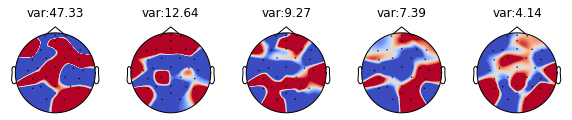

In [20]:
var = pca.explained_variance_ratio_

fig2, ax = plt.subplots(ncols=pcs.shape[1], figsize=(10, 3), gridspec_kw=dict(top=0.9),
                        sharex=True, sharey=True)


for p in range(pcs.shape[1]):
    mne.viz.plot_topomap(pcs[:,p], info_eeg, 
                         cmap='coolwarm', vmin=-100,vmax=100, contours=0,
                         axes=ax[p],show=False)
    
    ax[p].set_title('var:'+str(round(var[p]*100,2)) )

In [21]:
# plt.figure(figsize=(15,10))
# s_rate=128
# start=0
# end=60

# x = np.arange(0, df_all_eeg_data.T.shape[1])/128
# #y = gfp.
# plt.plot(x, gfp.values)
# plt.xlabel('tiempo [S]', fontsize=24)
# plt.ylabel('GFP', fontsize=20)
# plt.title(f'GFP y picos cada 80ms Sujeto Pos', fontsize=24)
# peaks, _ = find_peaks(gfp, height=(0,np.inf),distance=10)
# for ind in peaks:
#     plt.plot(x[ind],gfp[ind],'ro')

# # plt.savefig(f'../images/grafico_GFP_sujeto_{sujeto}_pos')
# plt.show()

# Tarea 2: Calculo de microestados utilizando k-means modificados
Aplicar el algoritmo de K-means modificado sobre los PGF P . Utilizar k = 2 − 10. ¿Es necesario repetir el procedimiento más de una vez para cada valor de k?
Decidir el mejor valor de k. Calcular el promedio de Silhoutte, el parámetro de Validación Cruzada y la Variancia global explicada para cada k. Relizar gráfico de las tres medidas para el k correspondiente.
Para el valor de k óptimo realizar el perfil de Silhoutte completo. Inspeccionar, a partir de esta última figura, la presencia de outliers, si es necesario descartarlos del análisis y volver a calcular los clusters para este valor de k.

In [22]:
from utils import kmeans3

In [24]:
maps, L, cv = kmeans3(X.values, gfp_values, 2)

## ¿Es necesario repetir el procedimiento más de una vez para cada valor de k? Supongo que hay que hacer un CV ya que hay una inicialización random al principio

In [31]:
cv

27.512576336121274

## Hacer el for loop sobre k 2 - 10. Calcular el silhoutte y ver cuales son las otras métricas. Todas meterlos en un dataframe.

# Tarea 3: Validación externa de los microestados
Realizar al menos dos métodos de clustering diferentes para los ~xn. Determinar la distancia que va a utilizar. Justificar brevemente porque se eligen esos métodos y nociones de distancia. Realice una inspección de las características de los clusters hallados y de los prototipos de cada cluster en caso que los hubiese (o de ejemplos en el caso que no), comparar con los encontrados por el método de k-means modificado.
Calcular la matriz de confusión entre algoritmos. Determinar el índice Rand.

## Franco

# Tarea 4: Visualización
Para los distintos algoritmos, visualizar los datos y las etiquetas de cluster asignadas en baja dimensión con alguna técnica de reducción (PCA, TSNE, MDS, etc). Esto se puede repetir para alguna variación que encuentren interesante, como para distintos valores de k o distintas nociones de distancia.

# Tarea 5: Comparación de medidas de los microestados
Calcule el ajuste de los datos de EEG a los prototipos de microestados hallados en la
Tarea 2 para cada registro. Realice un suavizado de las series temporales (puede utilizar
una ventana promedio móvil) y asigne a cada punto temporal el mapa prototipo que presente
mayor correlación.
A partir de aca debe elegir al menos uno de los siguientes medidas para comparar entre
ambas condiciones experimentales (antes y después del aprendizaje): (ver medidas en d’Croz
-Baron y colaboradores [3])
Duración promedio de cada microestado.
Frecuencia de ocurrencia.
Fracción de tiempo cubierto.
Global Explanined Variance.